# Timeseries forecasting for gas sensors prediction

Setup

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
!pip install pandas

In [3]:
import pandas as pd
df = pd.read_csv('C:\\Users\\Mirela\\PycharmProjects\\KALYPSO\\dataset tempMod CO_RH\\20160930_203718.csv')
df

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),...,1.2534,1.4449,1.9906,1.3303,1.4480,1.9148,3.4651,5.2144,6.5806,8.6385
0,0.309,0.0,55.84,26.62,241.6323,0.2112,2.1314,5.3552,9.7569,6.3188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.618,0.0,55.84,26.62,241.3888,0.2070,10.5318,22.5612,37.2635,17.7848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.926,0.0,55.84,26.62,241.1461,0.2042,29.5749,49.5111,65.6318,26.1447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.234,0.0,55.84,26.62,240.9121,0.2030,49.5111,67.0368,77.8317,27.9625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.544,0.0,55.84,26.62,240.8361,0.2020,60.1083,74.3444,81.5100,29.7970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295713,90908.545,0.0,62.30,26.58,0.0000,0.2000,5.5429,2.5713,10.3815,18.5796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295714,90908.853,0.0,62.30,26.58,0.0000,0.2000,4.5527,2.1454,8.5494,18.0592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295715,90909.162,0.0,62.30,26.58,0.0000,0.2000,3.7374,1.8492,7.1062,18.0087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295716,90909.469,0.0,62.30,26.58,0.0000,0.2000,3.1197,1.6190,5.9138,17.6950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295718 entries, 0 to 295717
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Time (s)            295718 non-null  float64
 1   CO (ppm)            295718 non-null  float64
 2   Humidity (%r.h.)    295718 non-null  float64
 3   Temperature (C)     295718 non-null  float64
 4   Flow rate (mL/min)  295718 non-null  float64
 5   Heater voltage (V)  295718 non-null  float64
 6   R1 (MOhm)           295718 non-null  float64
 7   R2 (MOhm)           295718 non-null  float64
 8   R3 (MOhm)           295718 non-null  float64
 9   R4 (MOhm)           295718 non-null  float64
 10  R5 (MOhm)           295718 non-null  float64
 11  R6 (MOhm)           295718 non-null  float64
 12  R7 (MOhm)           295718 non-null  float64
 13  R8 (MOhm)           295718 non-null  float64
 14  R9 (MOhm)           295718 non-null  float64
 15  R10 (MOhm)          295718 non-nul

In [5]:
df = df.iloc[:,0:20].copy()

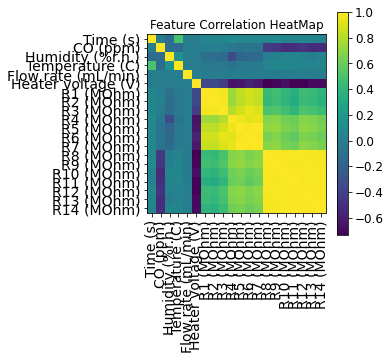

In [6]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    plt.title("Feature Correlation HeatMap", fontsize=12)
    plt.show()


show_heatmap(df)



Data Preprocessing

We are picking  207.002 data points for training. Observation is recorded every 0.309s. We will resample one point per 10 observation points. We do this via the sampling_rate argument in timeseries_dataset_from_array utility.

We are tracking data from past 1200 timestamps.
This data will be used to predict the CO concentration after 120 timestamps.

Since every feature has values with varying ranges, we do normalization to confine feature values to a range of [0, 1] before training a neural network. We do this by subtracting the mean and dividing by the standard deviation of each feature.

70.00 % of the data will be used to train the model, i.e. 207.002 rows.
The CO concentration after 120  observation will be used as a label.


In [7]:
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))
step = 10
past = 1200
future = 120
learning_rate = 0.001
batch_size = 256
epochs = 10


We can see from the correlation heatmap, few parameters  are redundant. We will be using select features, not all.

In [8]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


features = df[['Time (s)','CO (ppm)','Flow rate (mL/min)' ,'Heater voltage (V)','R1 (MOhm)','R2 (MOhm)','R3 (MOhm)','R4 (MOhm)','R5 (MOhm)','R6 (MOhm)']]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

Training dataset

The training dataset labels starts from the 1320nd observation (1200 + 120).

In [9]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(10)]].values
y_train = features.iloc[start:end][[1]]
sequence_length = int(past / step)

The timeseries_dataset_from_array function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of sub-timeseries inputs and targets sampled from the main timeseries.

In [10]:
import tensorflow as tf
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)



Validation dataset

The validation dataset must not contain the last 1320 rows as we won't have label data for those records, hence 1320 must be subtracted from the end of the data.

The validation label dataset must start from 1320 after train_split,  we must add past + future (1320) to label_start.


In [11]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(10)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (256, 120, 10)
Target shape: (256, 1)


Training

In [12]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 10)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5504      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


We'll use the ModelCheckpoint callback to regularly save checkpoints, and the EarlyStopping callback to interrupt training when the validation loss is not longer improving.

In [13]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
804/804 [==============================] - ETA: 0s - loss: 0.2074
Epoch 00001: val_loss improved from inf to 0.07538, saving model to model_checkpoint.h5
804/804 [==============================] - 90s 112ms/step - loss: 0.2074 - val_loss: 0.0754
Epoch 2/10
804/804 [==============================] - ETA: 0s - loss: 0.1306- ETA: 
Epoch 00002: val_loss improved from 0.07538 to 0.05483, saving model to model_checkpoint.h5
804/804 [==============================] - 92s 115ms/step - loss: 0.1306 - val_loss: 0.0548
Epoch 3/10
804/804 [==============================] - ETA: 0s - loss: 0.1218
Epoch 00003: val_loss improved from 0.05483 to 0.04984, saving model to model_checkpoint.h5
804/804 [==============================] - 92s 114ms/step - loss: 0.1218 - val_loss: 0.0498
Epoch 4/10
804/804 [==============================] - ETA: 0s - loss: 0.1186
Epoch 00004: val_loss improved from 0.04984 to 0.04732, saving model to model_checkpoint.h5
804/804 [==============================] - 94

We can visualize the loss with the function below. After one point, the loss stops decreasing.

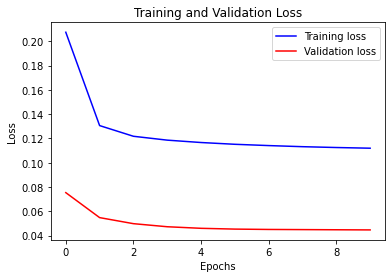

In [14]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

Prediction

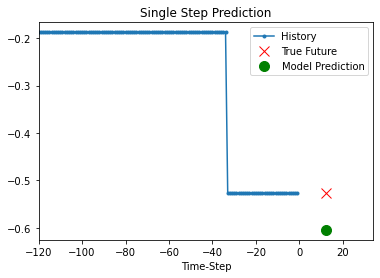

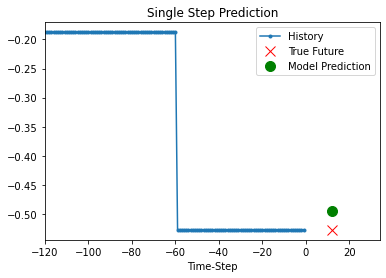

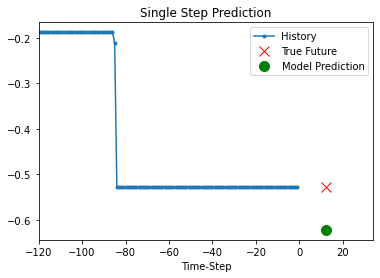

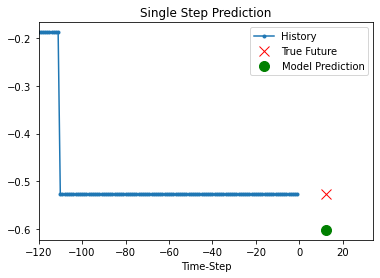

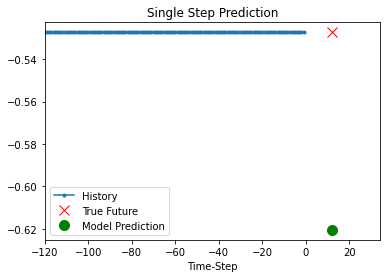

In [15]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )